In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:

from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import r
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")


In [6]:

def predict_survival(fp_model, newdata, max_time=None, n_grid=100, se_fit=False):
    """
    Predict survival probabilities from a fitted rstpm2 model in Python.

    Args:
        fp_model: Fitted stpm2 R model object (via rpy2).
        newdata: pandas DataFrame with covariates for prediction.
        max_time: float, maximum time to predict up to. If None, uses max of newdata['time'] if exists, else 1.
        n_grid: number of points in time grid.
        se_fit: bool, whether to include standard errors (for confidence intervals).

    Returns:
        pandas DataFrame with columns:
            - time
            - surv
            - lower (optional, if se_fit=True)
            - upper (optional, if se_fit=True)
    """
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()

    r_predict = r['predict']
    
    # Convert pandas newdata -> R data.frame
    r_newdata = pandas2ri.py2rpy(newdata)

    # Call R predict preserving original R object
    with localconverter(default_converter):
        surv_pred_raw = r_predict(
            fp_model,
            newdata=r_newdata,
            type="surv",
            grid=True,
            se_fit=se_fit
        )
    
    # Convert R list -> R dataframe
    surv_pred_df_r = r['as.data.frame'](surv_pred_raw)
    
    # rpy2 auto-converts data.frame -> pandas DataFrame
    surv_values = surv_pred_df_r.iloc[:, 0].values  # first column has survival estimates
    
    # Create time grid
    if max_time is None:
        # Try to infer max time from newdata['time'] if exists
        if 'time' in newdata.columns:
            max_time = newdata['time'].max()
        else:
            max_time = 1.0  # fallback
    time_grid = np.linspace(0, max_time, len(surv_values))
    
    # Build DataFrame
    df = pd.DataFrame({
        "time": time_grid,
        "surv": surv_values
    })
    
    # Add confidence intervals if available
    if se_fit:
        if 'lower' in surv_pred_df_r.columns and 'upper' in surv_pred_df_r.columns:
            df['lower'] = surv_pred_df_r['lower'].values
            df['upper'] = surv_pred_df_r['upper'].values
        else:
            import warnings
            warnings.warn("se_fit=True but CI columns not found in R output")
    
    return df


In [7]:
dfs = pd.read_csv('survival_data.csv')
df1 = dfs.copy()
df1.head(3)


,time,event,age,treatment
0,7.483810,1,64.967142,1
1,22.360127,0,58.617357,1
2,6.562908,1,66.476885,0


In [8]:

with conversion.localconverter(pandas2ri.converter):
    r_df = pandas2ri.py2rpy(df1)

In [9]:
# Define the formula
formula = Formula('Surv(time, event) ~ age + treatment')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df, df=3)


In [11]:
# new_data for prediction
new_data = pd.DataFrame({
    "age": [60, 50],
    "treatment": [1, 0]
})


In [12]:
# Predict survival
surv_df = predict_survival(fp_model, new_data, max_time=12, se_fit=False)


DeprecationWarning: 
The activate and deactivate are deprecated. To set a conversion
context check the docstring for rpy2.robjects.conversion.Converter.context.


In [ ]:

print(surv_df.head())

# Plot
import matplotlib.pyplot as plt
plt.plot(surv_df["time"], surv_df["surv"], label="Survival")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curve")
plt.show()


In [13]:
import numpy as np
import pandas as pd
from rpy2.robjects import r, Formula
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri

def predict_survival(fp_model, newdata, max_time=None, n_grid=100, se_fit=False):
    """
    Predict survival probabilities from a fitted rstpm2 model in Python.

    Args:
        fp_model: Fitted stpm2 R model object (via rpy2).
        newdata: pandas DataFrame with covariates for prediction.
        max_time: float, maximum time to predict up to. If None, uses max of newdata['time'] if exists, else 1.
        n_grid: number of points in time grid.
        se_fit: bool, whether to include standard errors (for confidence intervals).

    Returns:
        pandas DataFrame with columns:
            - time
            - surv
            - lower (optional, if se_fit=True)
            - upper (optional, if se_fit=True)
    """
    r_predict = r['predict']

    with localconverter(default_converter + pandas2ri.converter):
        # Convert newdata to R data.frame
        r_newdata = pandas2ri.py2rpy(newdata)

        # Call R predict, preserving R objects
        surv_pred_raw = r_predict(
            fp_model,
            newdata=r_newdata,
            type="surv",
            grid=True,
            se_fit=se_fit
        )

        # Convert R list -> R dataframe -> pandas DataFrame
        surv_pred_df_r = r['as.data.frame'](surv_pred_raw)

    # Extract survival estimates
    surv_values = surv_pred_df_r.iloc[:, 0].values  # first column has survival probabilities

    # Create time grid
    if max_time is None:
        if 'time' in newdata.columns:
            max_time = newdata['time'].max()
        else:
            max_time = 1.0
    time_grid = np.linspace(0, max_time, len(surv_values))

    # Build DataFrame
    df = pd.DataFrame({
        "time": time_grid,
        "surv": surv_values
    })

    # Add confidence intervals if available
    if se_fit:
        if 'lower' in surv_pred_df_r.columns and 'upper' in surv_pred_df_r.columns:
            df['lower'] = surv_pred_df_r['lower'].values
            df['upper'] = surv_pred_df_r['upper'].values
        else:
            import warnings
            warnings.warn("se_fit=True but CI columns not found in R output")

    return df


In [14]:
new_data = pd.DataFrame({
    "age": [60, 50],
    "treatment": [1, 0]
})

surv_df = predict_survival(fp_model, new_data, max_time=12, se_fit=False)
print(surv_df.head())

import matplotlib.pyplot as plt
plt.plot(surv_df["time"], surv_df["surv"])
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curve")
plt.show()


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [15]:
import numpy as np
import pandas as pd
from rpy2.robjects import r, Formula
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import FloatVector

def predict_survival(fp_model, newdata, max_time=None, n_grid=100, se_fit=False):
    """
    Predict survival probabilities from a fitted rstpm2 model in Python.

    Handles single-row and multi-row predictions robustly.

    Args:
        fp_model: fitted stpm2 R model object
        newdata: pandas DataFrame
        max_time: maximum time to predict
        n_grid: number of points in time grid
        se_fit: include confidence intervals (not always available)

    Returns:
        pandas DataFrame with columns: time, surv, (optional lower/upper)
    """
    r_predict = r['predict']

    with localconverter(default_converter + pandas2ri.converter):
        # Convert newdata to R data.frame
        r_newdata = pandas2ri.py2rpy(newdata)

        # Call R predict
        surv_pred_raw = r_predict(
            fp_model,
            newdata=r_newdata,
            type="surv",
            grid=True,
            se_fit=se_fit
        )

    # If result is a numeric vector (single individual), wrap it in a DataFrame
    if isinstance(surv_pred_raw, FloatVector):
        surv_values = np.array(surv_pred_raw)
        # Create time grid
        if max_time is None:
            max_time = 1.0  # fallback
        time_grid = np.linspace(0, max_time, len(surv_values))
        df = pd.DataFrame({
            "time": time_grid,
            "surv": surv_values
        })
        return df

    # Otherwise, convert to DataFrame (multi-row prediction)
    surv_pred_df_r = r['as.data.frame'](surv_pred_raw)
    surv_values = surv_pred_df_r.iloc[:, 0].values  # first column

    if max_time is None:
        if 'time' in newdata.columns:
            max_time = newdata['time'].max()
        else:
            max_time = 1.0
    time_grid = np.linspace(0, max_time, len(surv_values))
    df = pd.DataFrame({
        "time": time_grid,
        "surv": surv_values
    })

    # Optional confidence intervals
    if se_fit:
        if 'lower' in surv_pred_df_r.columns and 'upper' in surv_pred_df_r.columns:
            df['lower'] = surv_pred_df_r['lower'].values
            df['upper'] = surv_pred_df_r['upper'].values

    return df


In [16]:
new_data = pd.DataFrame({
    "age": [60],  # single row works
    "treatment": [1]
})

surv_df = predict_survival(fp_model, new_data, max_time=12, se_fit=False)
print(surv_df.head())

import matplotlib.pyplot as plt
plt.plot(surv_df["time"], surv_df["surv"])
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curve")
plt.show()


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [18]:
import numpy as np
import pandas as pd
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri

def predict_survival_single(fp_model, newdata, max_time=12):
    """
    Predict survival for a single row in newdata.
    Returns a pandas DataFrame with time and survival probability.
    """
    r_predict = r['predict']

    # Convert pandas -> R data.frame for newdata
    with localconverter(default_converter + pandas2ri.converter):
        r_newdata = pandas2ri.py2rpy(newdata)

        # Call predict; this returns a numeric vector
        surv_pred = r_predict(fp_model, newdata=r_newdata, type="surv", grid=True)

    # Convert R numeric vector -> numpy array
    surv_values = np.array(surv_pred)

    # Create time grid
    time_grid = np.linspace(0, max_time, len(surv_values))

    # Build DataFrame
    df = pd.DataFrame({
        "time": time_grid,
        "surv": surv_values
    })
    return df


       time      surv
0  0.000000  0.998915
1  0.040268  0.997886
2  0.080537  0.996651
3  0.120805  0.995245
4  0.161074  0.993692


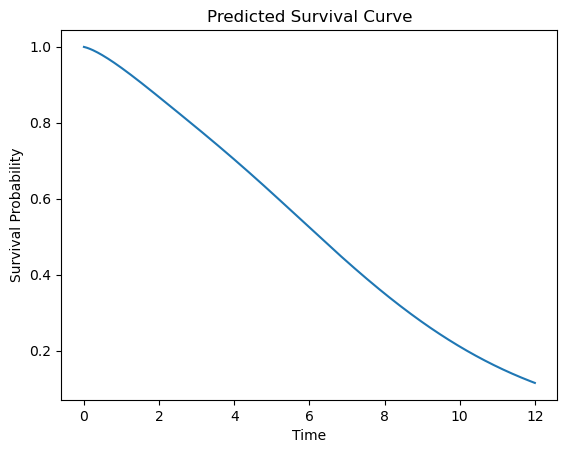

In [19]:
# Example: single row
new_data = pd.DataFrame({"age": [60], "treatment": [1]})
surv_df = predict_survival_single(fp_model, new_data, max_time=12)
print(surv_df.head())

import matplotlib.pyplot as plt
plt.plot(surv_df["time"], surv_df["surv"])
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curve")
plt.show()


In [23]:
import numpy as np
import pandas as pd
from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri

def predict_survival_multi(fp_model, newdata, max_time=None):
    """
    Predict survival curves for multiple rows in newdata.

    Args:
        fp_model: Fitted stpm2 R model object
        newdata: pandas DataFrame with covariates
        max_time: float, maximum time for survival curve. If None, set to 1.0

    Returns:
        pandas DataFrame in long format with columns:
        - id: row index of newdata
        - time: time points
        - surv: survival probability
    """
    r_predict = r['predict']

    if max_time is None:
        max_time = 1.0

    all_dfs = []

    # Loop over each row
    for idx, row in newdata.iterrows():
        row_df = pd.DataFrame([row])  # single-row DataFrame

        with localconverter(default_converter + pandas2ri.converter):
            r_row = pandas2ri.py2rpy(row_df)
            surv_pred = r_predict(fp_model, newdata=r_row, type="surv", grid=True)

        # Convert R numeric vector to numpy
        surv_values = np.array(surv_pred)
        n_points = len(surv_values)

        # Create time grid
        time_grid = np.linspace(0, max_time, n_points)

        # Build DataFrame
        df = pd.DataFrame({
            "id": idx,
            "time": time_grid,
            "surv": surv_values
        })

        all_dfs.append(df)

    # Concatenate all rows
    return pd.concat(all_dfs, ignore_index=True)


In [27]:
# Prepare new data with multiple rows
new_data = pd.DataFrame({
    "age": [60, 50, 70],
    "treatment": [1, 0, 1]
})

# Predict survival for all rows
surv_long = predict_survival_multi(fp_model, new_data, max_time=50)
print(surv_long.head(10))


   id      time      surv
0   0  0.000000  0.998915
1   0  0.167785  0.997886
2   0  0.335570  0.996651
3   0  0.503356  0.995245
4   0  0.671141  0.993692
5   0  0.838926  0.992010
6   0  1.006711  0.990214
7   0  1.174497  0.988314
8   0  1.342282  0.986320
9   0  1.510067  0.984240


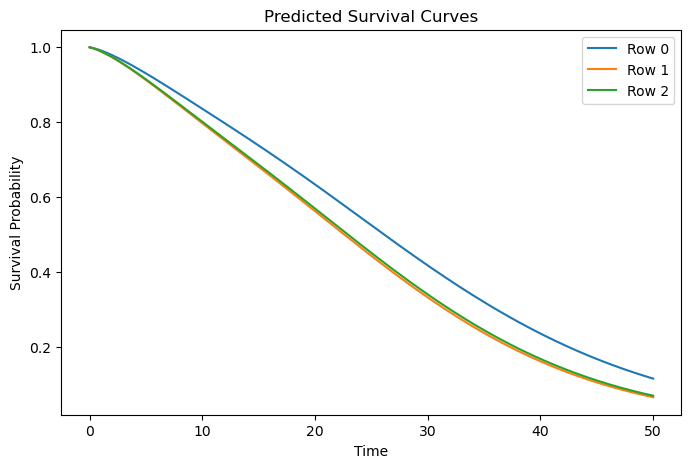

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for idx in surv_long['id'].unique():
    df = surv_long[surv_long['id'] == idx]
    plt.plot(df['time'], df['surv'], label=f'Row {idx}')

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves")
plt.legend()
plt.show()
